# Index Number: 180079X

# EN2550_Assignment5
## 1. Object Counting on a Convey Belt

## 1.0.1 Let’s first import required libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.0.2 Let’s load and visualize the template image and the convey belt snapshot at a given time.

In [2]:
#function to plot two images side by side with given titles
def plot(img,names):
    fig, ax = plt. subplots(1,2,figsize=(10,10))
    for i in range(2):
        ax[i].imshow(img[i], cmap='gray')
        ax[i].set_title(names[i])
    plt.show()
    return

In [3]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)
plot([template_im,belt_im],["Template Image","Belt Image"])

## 1.1 Part-I :

### 1.1.1 Otsu’s thresholding

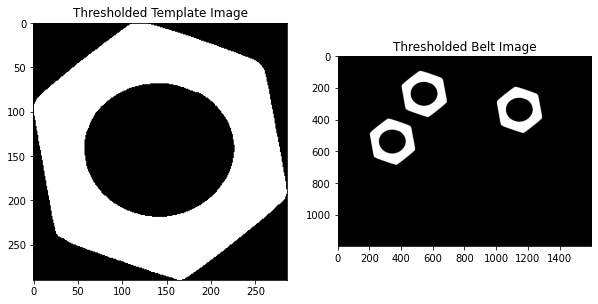

In [4]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plot([img_t,img_b],["Thresholded Template Image","Thresholded Belt Image"])

### 1.1.2 Morphological closing

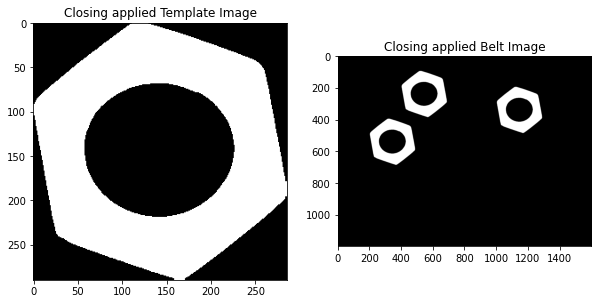

In [5]:
kernel = np.ones((3,3),np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)
plot([closing_t,closing_b],["Closing applied Template Image","Closing applied Belt Image"])

### 1.1.3 Connected component analysis

In [6]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)
print("No. of connected components_t : ",retval_t)
print("No. of connected components_b : ",retval_b)
print("----------------------------------------")
print("Statistics_t : \n",stats_t )
print("Statistics_b : \n",stats_b )
print("----------------------------------------")
print("Centroids_t : \n",centroids_t )
print("Centroids_b : \n",centroids_b )
print("----------------------------------------")

No. of connected components_t :  2
No. of connected components_b :  4
----------------------------------------
Statistics_t : 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
Statistics_b : 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
----------------------------------------
Centroids_t : 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]
Centroids_b : 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]
----------------------------------------



## • How many connected componets are detected in each image?

retval_t and retval_b returns number of connected components in each template and belt images respectively.<br> 
So,<br>
number of connected components in the template image = 2<br>
number of connected components in the belt image     = 4<br>
(including background label)

## • What are the statistics? Interpret these statistics.

Statistics include the statistics output for each label in relevant rows, including the background label. Columns include the ConnectedComponentsTypes, selecting the statistic. The data type is CV_32S.<br>
Those parameters are,<br>

1. The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
2. The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
3. The horizontal size of the bounding box.
4. The vertical size of the bounding box.
5. The total area (in pixels) of the connected component.

## • What are the centroids?

x and y coordinates of the centroid of each component is interpreted by relevant row.

### 1.1.4 Contour analysis

In [7]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #for template image
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #for belt image

As it is required to retrieve the extreme outer contours, I have used cv.RETR_EXTERNAL as the RetrievalMode of the function.

In [13]:
#print(contours_t)
aaa, xxx = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #for template image
print(len(aaa))

2


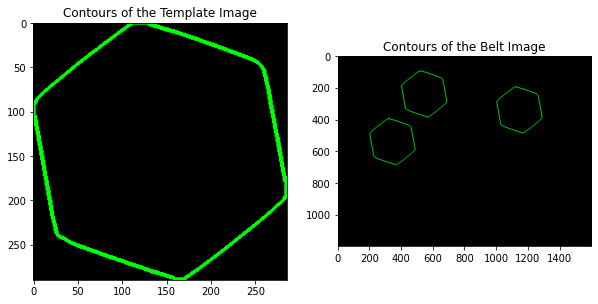

In [8]:
# Visualizing the extreme outer contours of the belt image
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
belt_conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')

# Visualizing the extreme outer contours of template image.
im_contours_template = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
template_conts = cv.drawContours(im_contours_template, contours_t, -1, (0,255,0), 3).astype('uint8')

plot([template_conts,belt_conts],["Contours of the Template Image","Contours of the Belt Image"])

### 1.1.5 Count the number of matching hexagonal nuts in belt.png.

In [9]:
label = 1 #remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')    #making the binary image
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #finding the outer contours
for j,c in enumerate(belt_cont):
    print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))  #   match with the template contour

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


- If the compared two contours are almost similar, matchShapes function will return a smaller value which is close to zero.

In [10]:
#count the number of nuts in the belt image
count_nuts = 0                                                        
for j,c in enumerate(belt_cont):
    match = cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0) #get the match value
    if match < 0.000100716984:
        count_nuts += 1 #count as a similar nut
print("Number of nuts in belt image: ",count_nuts)

Number of nuts in belt image:  3


## 1.2 Part - II

### 1.2.1 Frame tracking through image moments.

In [11]:
 ca = cv.contourArea(contours_b[1]) #area of the contour
 print(ca)

60059.5


In [12]:
M = cv.moments(contours_b[1])
print("Dictionary of moments: \n",M ,"\n")   #return dictionary
cx,cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])
print("Centroid coordinates:", (cx, cy))

Dictionary of moments: 
 {'m00': 60059.5, 'm10': 68611440.0, 'm01': 20630899.0, 'm20': 78674593714.08333, 'm11': 23570444412.958332, 'm02': 7371056517.75, 'm30': 90547806168118.9, 'm21': 27029588543966.05, 'm12': 8421847359458.05, 'm03': 2727315587271.4004, 'mu20': 293493324.0767517, 'mu11': 1888416.2457389832, 'mu02': 284184440.0903292, 'mu30': 79907847.171875, 'mu21': -52573545.19958496, 'mu12': -79587217.90814209, 'mu03': 62055311.556640625, 'nu20': 0.08136447047416653, 'nu11': 0.0005235212363099092, 'nu02': 0.07878379025377881, 'nu30': 9.039307270173402e-05, 'nu21': -5.947206014938962e-05, 'nu12': -9.003037159824198e-05, 'nu03': 7.019799040515873e-05} 

Centroid coordinates: (1142, 343)


In [13]:
print(M['m00']) #get area using moments

60059.5


In [14]:
count = 1 #number of contours
object_prev_frame = np.array([cx, cy, ca, count])
delta_x = 15

## 1.3 Part - III

### 1.3.1 1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)

In [15]:
def get_indexed_image(im):
    thrsh, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) #thresholding 
    kernel = np.ones((3,3),np.uint8)                                     #creating a kernel 
    closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)               #closing
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing) #connected component analysis
    return retval, labels, stats, centroids

### 1.3.2 2. Implement the function is_new, which checks the dissimilarity between 2 vectors. (Grading)

In [16]:
def is_new(a, b, delta, i):
    for rw in range(a.shape[0]):      #checking each row in a
        similar = True
        for indx in range(len(i)):    #getting indices to check
            if np.abs(a[rw,i[indx]]-b[i[indx]]) > delta[indx]:  #compare with the threshold values
                similar = False
                break   #that row is not similar
        if similar:
            return False                #return False if a row of 'a' is similar to 'b'
    return True

In [17]:
# check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert is_new(a, b, delta, i) == False, " Check the function "

### 1.3.3 3. If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of \[ cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame. (Grading)

In [18]:
def prev_index(a, b, delta, i):
    index = -1
    for cnt in range(a.shape[0]):
        if not(is_new(np.array([a[cnt]]), b, delta, i)): #check if similar
            index = cnt                                  #get the index of the similar frame in 'a'
    return index

In [19]:
# check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert prev_index(a,b,delta,i) == 1, " Check the function "

### 1.3.4 3. Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)

## 1.4 Steps:

In [11]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4')    #load video
while cap.isOpened():
    ret, frame = cap.read()      #access current frame
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)           #convert the frame into grayscale
    retval, labels, stats, centroids = get_indexed_image(grey)  #calling function to get the labeled image
    belt = ((labels >= 1)*255).astype('uint8')  #getting a binary image
    cont, hierarchy = cv.findContours(belt,  cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)   #find contours of all nuts
    im_blck = np.zeros(frame.shape, np.uint8)     #black image to draw the contours
    conts = cv.drawContours(im_blck, cont, -1, (0,255,0), 3).astype('uint8')    #draw each contours
    cv.namedWindow("Video", cv.WINDOW_NORMAL) 
    cv.imshow("Video",conts)    #show contours
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

NameError: name 'get_indexed_image' is not defined

## 1.5 Object detection and tracking

In [24]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4') #load the video
out = cv.VideoWriter('180079X_en2550_a05.mp4', -1 , 30.0, (1920,1080))  #Create the output video

#Find contours of the template image
retval_t, labels_t, stats_t, centroids_t = get_indexed_image(template_im)
temp = ((labels_t >= 1)*255).astype('uint8')
temp_cont, temp_hierarchy = cv.findContours(temp, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#parameters
a = np.array([])                  #array to store the moment data vectors of identified contours
i = np.array([0,1,2])           #indices to check with cx, cy and area in 'a'
delta = np.array([15,15,800])   #threshold values corresponding to above elements
frame_count = 0                 #frame number
anchor = (50,1000)                #anchor point coordinates for annotations
font = cv.FONT_HERSHEY_SIMPLEX    #font style of annotations

while cap.isOpened():
    ret, frame = cap.read() #read the current frame
    frame_count += 1        #incrementing the frame number
    indent = 0              #to get spaces between annotated lines
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)    #convert the frame to grayscale
    retval, labels, stats, centroids = get_indexed_image(grey)   #calling function to get the labeled image
    frame_trans = ((labels >= 1)*255).astype('uint8')   #getting a binary image
    contours, Hierarchy = cv.findContours(frame_trans, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #find contours in the frame
    im_blck = np.zeros(frame.shape, np.uint8)   #getting a black image to draw contours

    #Checking for each contour in the current frame
    for cont in contours:
        if cv.matchShapes(temp_cont[0], cont, cv.CONTOURS_MATCH_I1, 0.0) > 0.0008:#skipping current loop if the identified contour of the frame is not similar to the template contour
            continue    
        #getting moments data
        ca = cv.contourArea(cont)   #area
        M = cv.moments(cont)
        cx, cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])    #centroid
        count = 1 #number of contours
        object_curr_frame = np.array([cx, cy, ca, count])

        #build 'a' and get contour index
        if a.shape[0] == 0:       #check if 'a' is empty
            a = (np.append(a,object_curr_frame)).reshape((1,4))   #append moment data of the first contour and set the dimensions
            indx = a.shape[0]-1  #get the index of the current contour

        elif is_new(a, object_curr_frame, delta, i):   #check if the current contour has been detected before
            a = np.concatenate((a,np.array([object_curr_frame])),axis=0)  #appending the moment data vector of it
            indx = a.shape[0]-1  #get the index of the contour
        else:
            indx = prev_index(a, object_curr_frame, delta, i)   #finding the index of contour in 'a' when it has been detected before
            a[indx] = object_curr_frame    #update the cooresponding location of 'a' with current moment data vector 

        #annotations
        cv.putText(im_blck,str(indx+1),(cx,cy), font, 2,(255,0,255),2,cv.LINE_AA) #show the index of current contour at the centroid of it
        text = "Object "+str(indx+1)+": "+str(a[indx,0])+", "+str(a[indx,1])+", "+str(a[indx,2]) #annotation text for current contour data
        cv.putText(im_blck,text,(anchor[0],anchor[1]-indent), font, 1.5,(255,0,255),2,cv.LINE_AA)#show the data of current contour(bottom to top)
        indent += 50 #increment the indent for the spacing of lines
        
    cv.putText(im_blck,"Frame:"+str(frame_count),(anchor[0],anchor[1]-indent), font, 1.5,(0,255,0),2,cv.LINE_AA) #show the frame number
    cv.putText(im_blck,"Index Number: "+str(180079)+"X",(anchor[0],50), font, 1.5,(0,0,255),2,cv.LINE_AA)    #show the index number
    frame_out = cv.drawContours(im_blck, contours, -1, (0,255,0), 3).astype('uint8')  #draw the contours
    cv.namedWindow("Video", cv.WINDOW_NORMAL)    
    cv.imshow("Video",frame_out)   #show the current frame output
    out.write(frame_out)    #write the current frame output to the video file

    if cv.waitKey(1) == ord('q'):
        break
cap.release()
out.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
